In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from  statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
plt.rcParams["figure.figsize"] = [18, 8]

# Этот набор данных содержит информацию о погоде в городе Дели(Индия)
# с 1 января 2013 года по 24 апреля 2017 года.
Данные имеют несколько параметров:
1) Дата (date);
2) Влажность (humidity);
3) Средняя температура (meantemp);
4) Скорость ветра (wind_speed);
5) Среднее давление (meanpressure).

In [9]:
df_train = pd.read_csv('data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)
df = pd.concat([df_train, df_test])

Посмотрим данные:

In [10]:
print(f'Кол-во строк в тренировочных данных: {len(df_train)}')
print(f'Кол-во строк в тестовых данных: {len(df_test)}')
print(f'Кол-во строк во всем датасете: {len(df)}')

Кол-во строк в тренировочных данных: 1462
Кол-во строк в тестовых данных: 114
Кол-во строк во всем датасете: 1576


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1576 non-null   float64
 1   humidity      1576 non-null   float64
 2   wind_speed    1576 non-null   float64
 3   meanpressure  1576 non-null   float64
dtypes: float64(4)
memory usage: 61.6 KB


Все столбцы имеют тип float

In [12]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Пропусков в тренировочных данных нет.

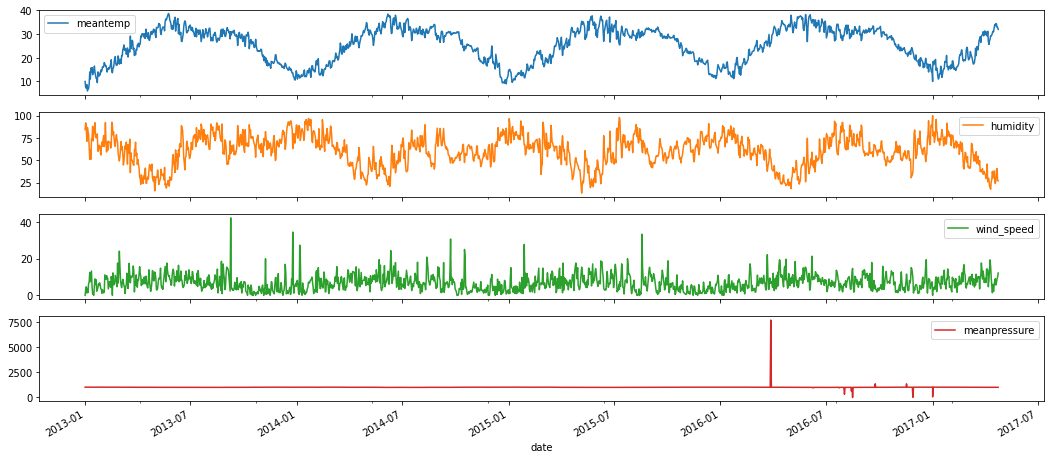

In [13]:
df.plot(subplots=True)
plt.show()

In [14]:
for c in df.columns:
    af = adfuller(df[c])
    print(c)
    print(f'adf: {af[0]}')
    print(f'p-value: {af[1]}')
    print(f'Critical values: {af[4]}')
    if af[0] > af[4]['5%']:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')
    print('\n')

meantemp
adf: -2.3791899484520926
p-value: 0.14769623489792355
Critical values: {'1%': -3.4345353407734733, '5%': -2.86338857621683, '10%': -2.567754150088293}
Ряд не стационарен


humidity
adf: -3.6289421593858777
p-value: 0.005231221485558025
Critical values: {'1%': -3.4345487774977768, '5%': -2.8633945067663817, '10%': -2.5677573081032214}
Ряд стационарен


wind_speed
adf: -4.01322099000784
p-value: 0.0013428427295095503
Critical values: {'1%': -3.434573182279212, '5%': -2.863405278205157, '10%': -2.567763043900464}
Ряд стационарен


meanpressure
adf: -39.54736593013774
p-value: 0.0
Critical values: {'1%': -3.434508723681996, '5%': -2.863376828187341, '10%': -2.567747894280675}
Ряд стационарен




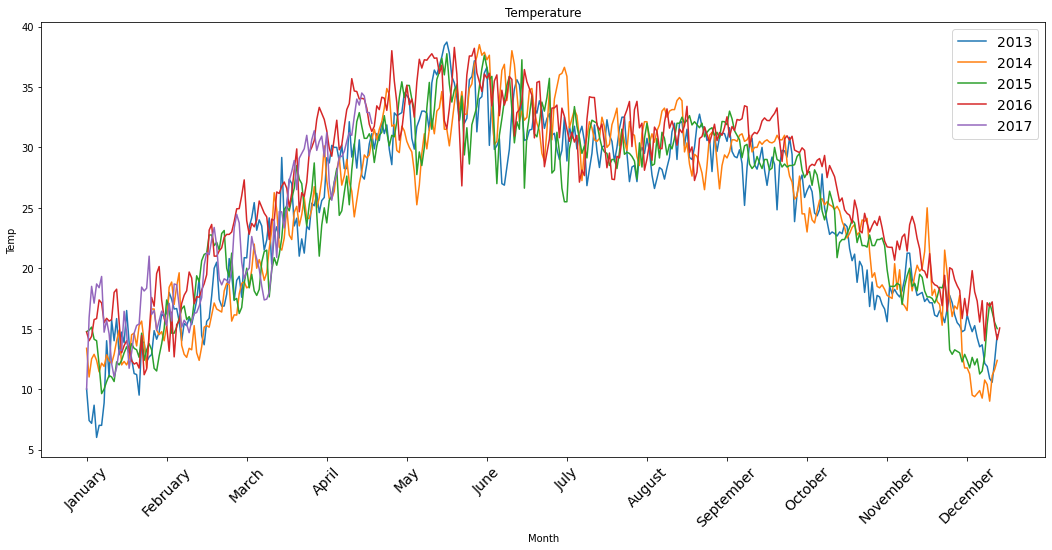

In [15]:
dates = pd.to_datetime(df.index)
plt.title('Temperature')
for y in dates.year.unique():
    plt.plot(df['meantemp'][dates.year==y].values, label=y)
plt.xlabel('Month')
plt.ylabel('Temp')
plt.xticks(np.arange(0, 365, 32), labels=dates.month_name().unique(), rotation=45, fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [32]:
df_m = pd.DataFrame(df_train['meantemp'].resample('M').mean())

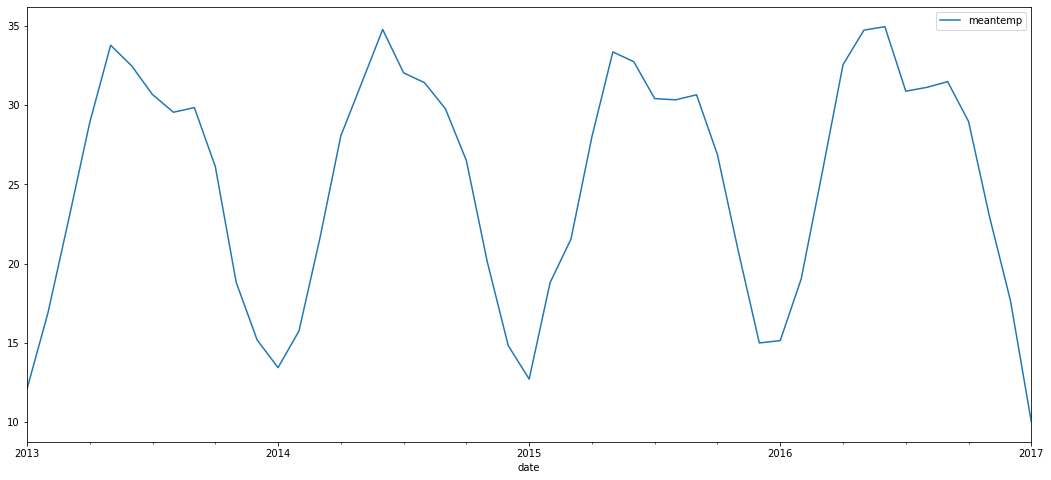

In [33]:
df_m.plot()
plt.show()

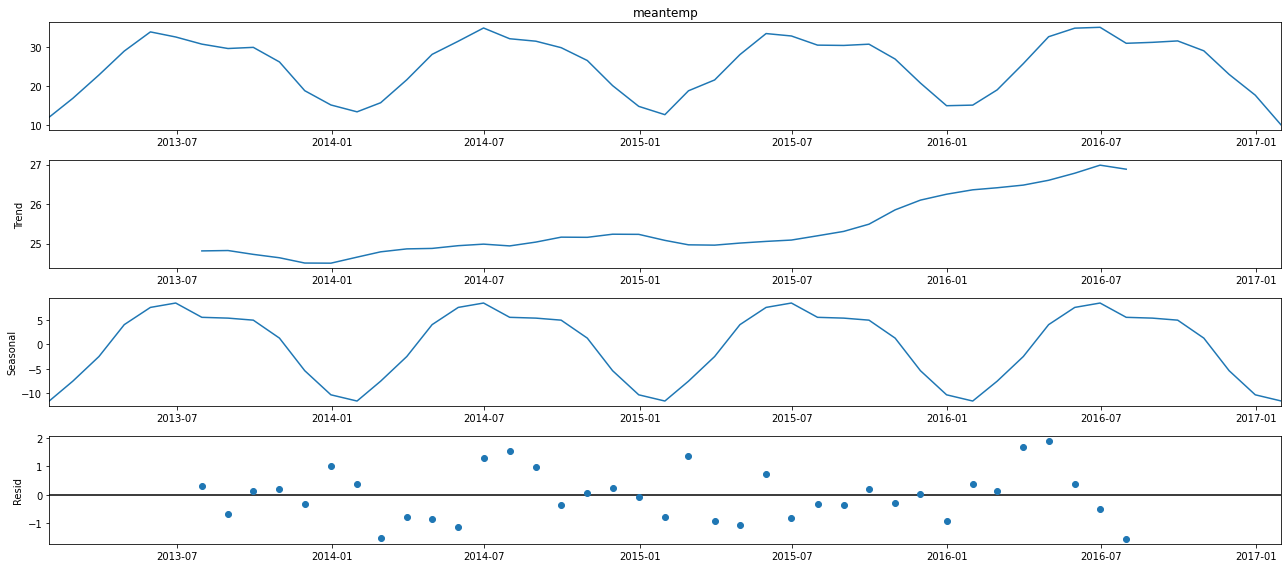

In [34]:
decomp = seasonal_decompose(df_m['meantemp'])
decomp.plot()
plt.show()

## SARIMAX

In [122]:
model = SARIMAX(df_m,
                  order=(2,0,2),
                  seasonal_order=(2,1,0,12))
results=model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                   49
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                 -67.034
Date:                             Tue, 19 Apr 2022   AIC                            148.067
Time:                                     16:53:24   BIC                            159.344
Sample:                                 01-31-2013   HQIC                           152.043
                                      - 01-31-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8779      0.222      3.958      0.000       0.443       1.313
ar.L2         -0.6574      

D:\PythonProject\TimeSeriesItmo\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


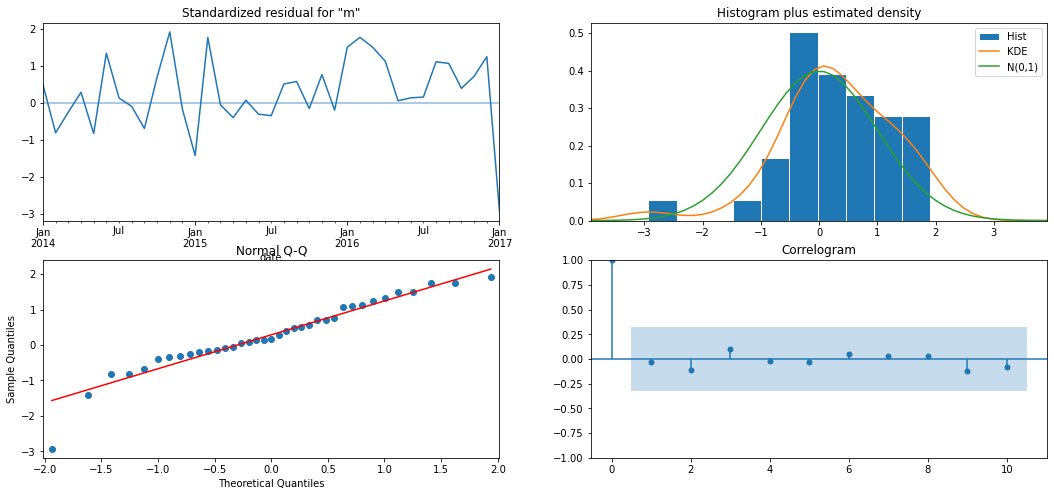

In [148]:
results.plot_diagnostics()
plt.show()

In [141]:
df_test_m = pd.DataFrame(df_test['meantemp'].resample('M').mean())
predictions= results.get_forecast(steps=24).predicted_mean

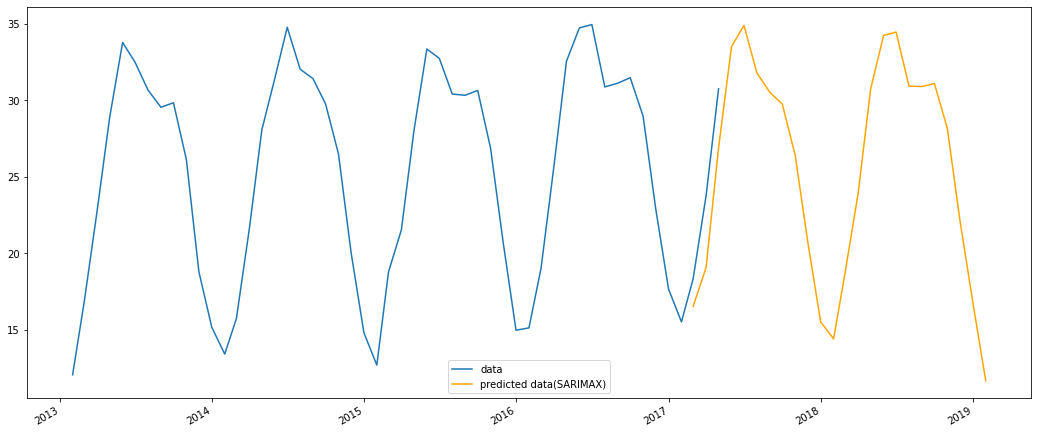

In [263]:
fig, ax = plt.subplots()
plt.plot(df['meantemp'].resample('M').mean())
predictions.plot(legend=True, color='orange')
ax.legend(['data', 'predicted data(SARIMAX)'])
plt.show()

In [147]:
mse = mean_squared_error(df_test_m, predictions[:4])
print(f'MSE = {mse}')

MSE = 4.651549403759187


In [146]:
rmse = np.sqrt(mse)
print(f'RMSE = {rmse}')

RMSE = 2.156745094757187


## LSTM

In [307]:
train = df_train[["meantemp"]].resample("M").mean()
test = df_test[["meantemp"]].resample("M").mean()

In [308]:
scaler = StandardScaler()
scaler.fit(df_m)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(train)
n_input = 9
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [309]:
model = Sequential()
model.add(LSTM(128, activation="relu", return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 9, 128)            66560     
                                                                 
 dropout_36 (Dropout)        (None, 9, 128)            0         
                                                                 
 lstm_37 (LSTM)              (None, 9, 128)            131584    
                                                                 
 dropout_37 (Dropout)        (None, 9, 128)            0         
                                                                 
 lstm_38 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 25)              

In [310]:
history = model.fit(generator, epochs=50)

Epoch 1/50
40/40 [==============================] - 5s 8ms/step - loss: 0.6335 - accuracy: 0.0000e+00
Epoch 2/50
40/40 [==============================] - 0s 8ms/step - loss: 0.3639 - accuracy: 0.0000e+00
Epoch 3/50
40/40 [==============================] - 0s 8ms/step - loss: 0.3218 - accuracy: 0.0000e+00
Epoch 4/50
40/40 [==============================] - 0s 8ms/step - loss: 0.2321 - accuracy: 0.0000e+00
Epoch 5/50
40/40 [==============================] - 0s 8ms/step - loss: 0.1717 - accuracy: 0.0000e+00
Epoch 6/50
40/40 [==============================] - 0s 8ms/step - loss: 0.2513 - accuracy: 0.0000e+00
Epoch 7/50
40/40 [==============================] - 0s 8ms/step - loss: 0.1615 - accuracy: 0.0000e+00
Epoch 8/50
40/40 [==============================] - 0s 8ms/step - loss: 0.1683 - accuracy: 0.0000e+00
Epoch 9/50
40/40 [==============================] - 0s 9ms/step - loss: 0.1928 - accuracy: 0.0000e+00
Epoch 10/50
40/40 [==============================] - 0s 8ms/step - loss: 0.1622 - 

In [311]:
predictions_scaled_lstm = []
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(24):
     current_pred = model.predict(current_batch)[0]
     predictions_scaled_lstm.append(current_pred)
     current_batch =  np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [312]:
predictions_lstm = scaler.inverse_transform(predictions_scaled_lstm)

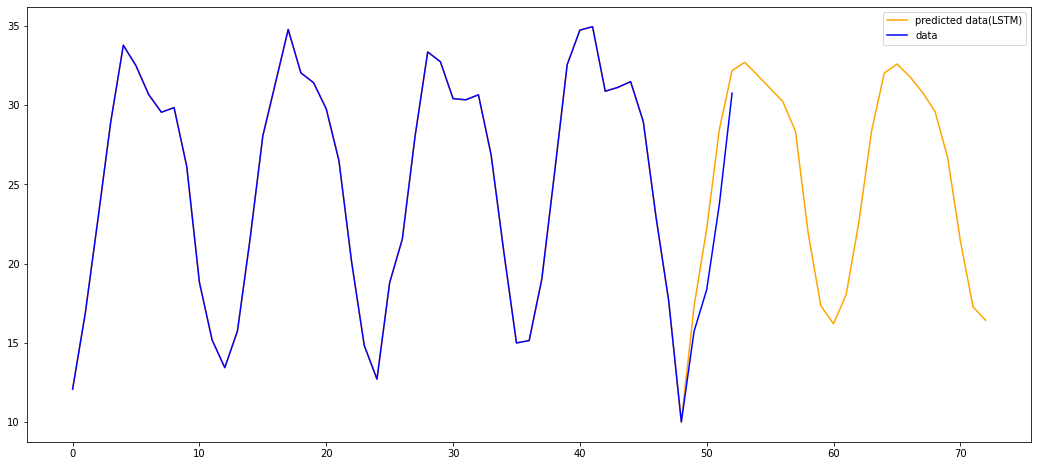

In [313]:
fig, ax = plt.subplots()
plt.plot(np.append(train, predictions_lstm), color="orange")
plt.plot(np.append(train, test), color="blue")
ax.legend(['predicted data(LSTM)', 'data'])
plt.show()

In [314]:
mse = mean_squared_error(test, predictions[:len(test)])
print(f'MSE = {mse}')

MSE = 4.651549403759187


In [315]:
rmse = np.sqrt(mse)
print(f'RMSE = {rmse}')

RMSE = 2.156745094757187
